## Accessing NASADEM data on Azure (COG)

The [Copernicus DEM](https://spacedata.copernicus.eu/explore-more/news-archive/-/asset_publisher/Ye8egYeRPLEs/blog/id/434960) is a digital surface model (DSM), which represents the surface of the Earth including buildings, infrastructure, and vegetation. This DSM is based on radar satellite data acquired during the TanDEM-X Mission, which was funded by a public-private partnership between the German Aerospace Centre (DLR) and Airbus Defence and Space. Copernicus DEM is available at both 30-meter and 90-meter resolution.

Copernicus DEM is available on Azure in cloud-optimized GeoTIFF (COG) format; COG files were sourced from [OpenTopography](https://portal.opentopography.org/datasetMetadata?otCollectionID=OT.032021.4326.1).

This notebook demonstrates access to Copernicus DEM data from blob storage on Azure, including (1) finding the Copernicus DEM tile corresponding to a lat/lon coordinate and (2) opening and plotting the tile.

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This dataset is documented at [aka.ms/ai4edata-copernicus-dem](http://aka.ms/ai4edata-copernicus-dem).

### Imports and environment

In [15]:
import os
import math
import requests

import rasterio as rio
from rasterio import plot
from matplotlib import pyplot as plt

account_name = 'elevationeuwest'
container_name = 'copernicus-dem'
account_url = 'https://' +account_name + '.blob.core.windows.net'
blob_root = account_url + '/' + container_name + '/v001/'

# A full list of files is available at:
#
# https://nasademeuwest.blob.core.windows.net/nasadem-cog/v001/index/nasadem_cog_list.txt
file_index_url = blob_root + 'index/copernicus_dem_cog_list.txt'

cdem_content_extension = '.tif'

# This will contain a list of all available .tif files
cdem_file_list = None

### Read the file list

In [21]:
f = requests.get(nasadem_file_index_url)
nasadem_file_list = f.text
nasadem_file_list = nasadem_file_list.split('\n')
print('Read list of {} available files'.format(len(nasadem_file_list)))

Read list of 14523 available files


### Functions

In [22]:
def lat_lon_to_nasadem_tile(lat,lon):
    """
    Get the NASADEM file name for a specified latitude and longitude
    """
    
    # A tile name looks like:
    #
    # NASADEM_HGT_n00e016.tif
    #
    # The translation from lat/lon to that string is represented nicely at:
    #
    # https://dwtkns.com/srtm30m/
    ns_token = 'n' if lat >=0 else 's'
    ew_token = 'e' if lon >=0 else 'w'
    
    lat_index = abs(math.floor(lat))
    lon_index = abs(math.floor(lon))
    
    lat_string = ns_token + '{:02d}'.format(lat_index)
    lon_string = ew_token + '{:03d}'.format(lon_index)
    
    filename = nasadem_file_prefix + lat_string + lon_string + \
        nasadem_content_extension

    if filename not in nasadem_file_list:
        print('Lat/lon {},{} not available'.format(lat,lon))
        filename = None
    
    return filename


### Load a NASADEM tile for a known lat/lon

In [23]:
# Interesting places for looking at SRTM data
everest = [27.9881,86.9250]
seattle = [47.6062,-122.3321]
grand_canyon = [36.101690, -112.107676]
mount_fuji = [35.3606, 138.7274]
mont_blanc = [45.832778, 6.865000]
invalid = [-15.1,41]

tile_of_interest = mount_fuji

tile_name = lat_lon_to_nasadem_tile(tile_of_interest[0],tile_of_interest[1])
url = nasadem_blob_root + tile_name
print('Plotting tile: {}'.format(tile_name))

Plotting tile: NASADEM_HGT_n35e138.tif


### Plot the tile

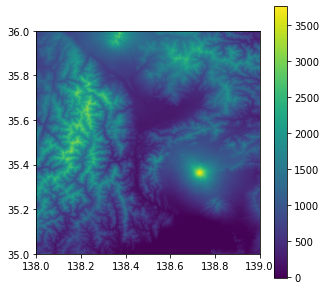

In [27]:
src = rio.open(url)
d = src.read(1)
fig, ax = plt.subplots(figsize=(5, 5))

# create a hidden image so we can add a colorbar
image_hidden = ax.imshow(d,cmap='viridis')

image = rio.plot.show(d, 
                      transform=src.transform, 
                      ax=ax, 
                      cmap='viridis')

fig.colorbar(image_hidden, ax=ax);